In [23]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from matplotlib import pyplot as plt
import numpy as np

## Import the dataset

Import the CIFAR-10 dataset from Keras using the load_data function

In [24]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Investigate and preprocess the dataset

Investigate the properties of the training and test data

In [25]:
print(f"Number of training data rows: {x_train.shape[0]}")
print(f"Number of test data rows: {x_test.shape[0]}")
print(f'Resolution of each image: {x_train.shape[1]} x {x_train.shape[2]}')
print(f'Number of channels: {x_train.shape[3]}')
print(f'Number of classes: {len(np.unique(y_train))}')

Number of training data rows: 50000
Number of test data rows: 10000
Resolution of each image: 32 x 32
Number of channels: 3
Number of classes: 10


We can see that there are 50,000 training images and 10,000 test images meaning that the dataset is split into ~83% training and ~17% test data. Each image is 32x32 pixels with 3 channels (RGB).

In order to effectively compare the models, we need to create a validation set. A good starting point is usually 80% training, 10% validation and 10% test data. Therefore, we will split the training data into 48,000 training, 6,000 validation and 6,000 testing images.

In [41]:
# Combine the training and test data
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

# Split the data into training, validation and test sets
x_train, x_val, x_test = np.split(x, [int(.8*len(x)), int(.9*len(x))])
y_train, y_val, y_test = np.split(y, [int(.8*len(y)), int(.9*len(y))])

Display an image corresponding to each of the 10 classes using matplotlib

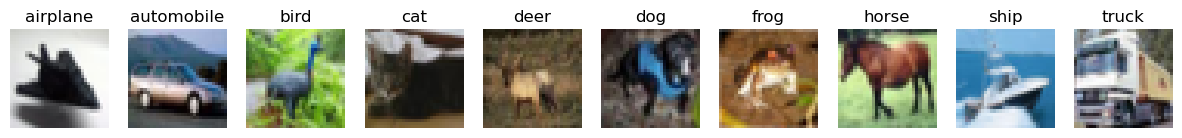

In [26]:
target_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

figure, axis = plt.subplots(1, 10, figsize=(15, 1.5))
for i, target in enumerate(target_names):
    axis[i].imshow(x_train[np.where(y_train==i)[0][0]])
    axis[i].set_title(target)
    axis[i].axis("off")
plt.show()

As the images use the RGB colour model, the pixel values for each image are positive integers in the range of [0,255]. Therefore, we need to normalise the pixel values into the range of [0,1].

In [42]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

## Evaluating model performance

Create a function to display the accuracy and loss of the model over the training and validation sets

In [49]:
def evaluate_model(history):
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

Create a function to calculate the accuracy and loss of the model on the test set

In [50]:
def test_model(model):
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}')
    print(f'Test loss: {test_loss}')

Create a function to display the confusion matrix of the model

In [51]:
def confusion_matrix(model):
    predictions = model.predict(x_test)
    predictions = np.argmax(predictions, axis=1)
    cm = tf.math.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

## Build a simple neural network

Create a simple neural network consisting of a single fully connected layer as a baseline

- It has an input layer with shape (32, 32, 3) corresponding to the 32x32 pixel images with 3 channels. This layer flattens the input image into a 1D array of length 3072.
- This 1D array is passed to a single fully connected layer with 10 neurons and a softmax activation function, where each neuron corresponds to a class.
- The output of the softmax activation function is a probability distribution over the 10 classes in the CIFAR-10 dataset.

In [46]:
def single_layer_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [60]:
model = single_layer_model()
history = model.fit(x_train, y_train, batch_size=512, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
45/45 [==============================] - 1s 10ms/step - loss: 2.2952 - accuracy: 0.1142 - val_loss: 2.2864 - val_accuracy: 0.1383
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 2.2812 - accuracy: 0.1228 - val_loss: 2.2732 - val_accuracy: 0.1592
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 2.2682 - accuracy: 0.1630 - val_loss: 2.2602 - val_accuracy: 0.1829
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 2.2558 - accuracy: 0.1890 - val_loss: 2.2480 - val_accuracy: 0.2129
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 2.2438 - accuracy: 0.2093 - val_loss: 2.2362 - val_accuracy: 0.2547
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 2.2326 - accuracy: 0.2531 - val_loss: 2.2249 - val_accuracy: 0.2659
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 2.2217 - accuracy: 0.2627 - val_loss: 2.2142 - val_accuracy: 0.2882
Epoch 8/100


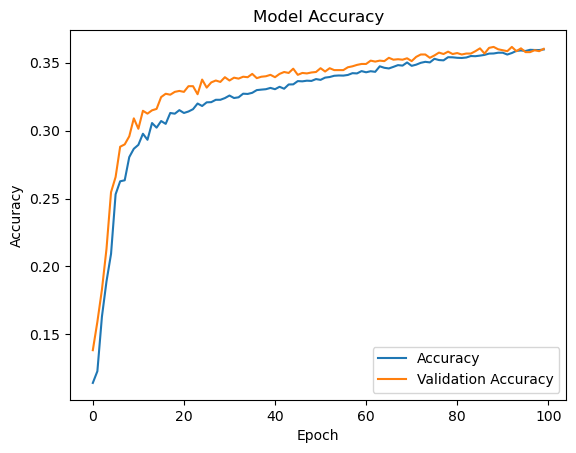

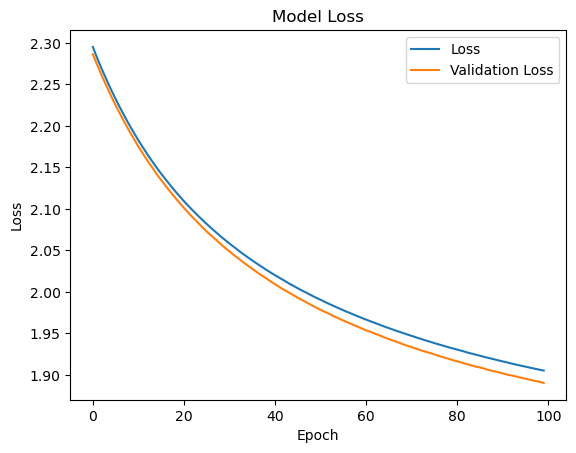

In [61]:
evaluate_model(history)

In [62]:
test_model(model)

90/90 - 0s - loss: 1.8982 - accuracy: 0.3547 - 185ms/epoch - 2ms/step
Test accuracy: 0.3547038435935974
Test loss: 1.8982077836990356


90/90 [==============================] - 0s 1ms/step


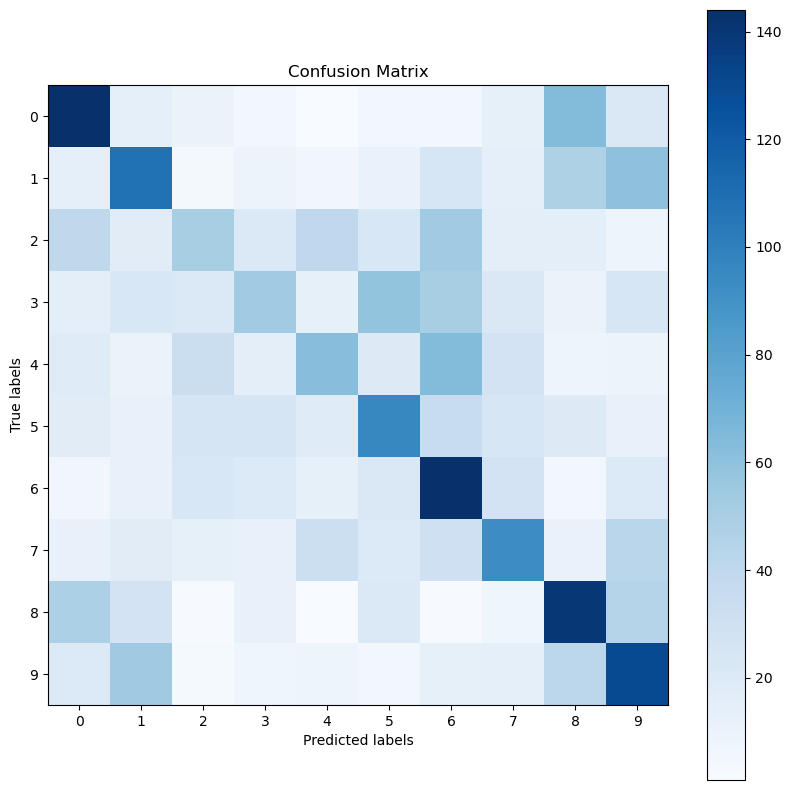

In [63]:
confusion_matrix(model)

## Build a